<a href="https://colab.research.google.com/github/raz0208/Advance-Quantitative-Research-Project/blob/main/Task4/Strategic_Bucketing_of_FICO_Scores_for_PD_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task 4: Bucket FICO scores**
# **Strategic Bucketing of FICO Scores for PD Modeling**
### Data-Driven Bucketing of Credit Scores Using MSE and Log-Likelihood Optimization

## **Step 1: Load And Read Dataset**


In [1]:
# Import Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load And Read Dateset
df = pd.read_csv('/content/Task 3 and 4_Loan_Data.csv')
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


In [4]:
# Create new dataframe with "fico_score" and "default"
fs_df = df[['fico_score', 'default']]
fs_df = fs_df.sort_values(by='fico_score').reset_index(drop=True) # Sort fs_df by "fisco_score"

fs_df.head()

,fico_score,default
0,408,0
1,409,1
2,418,1
3,425,1
4,438,1


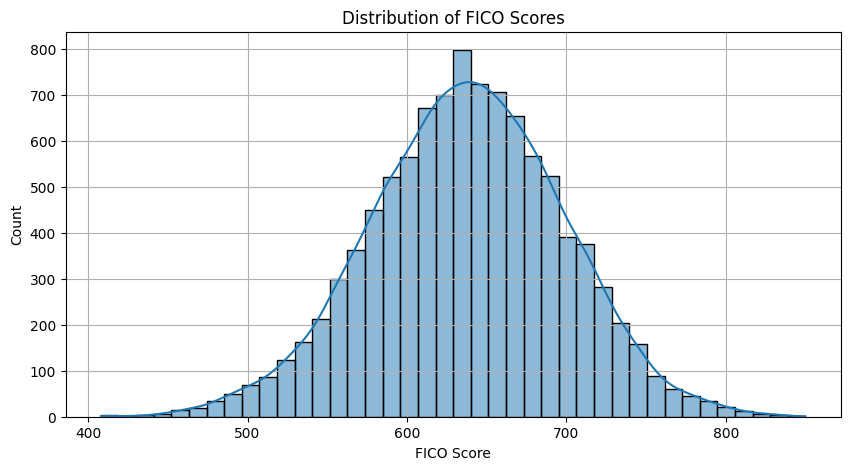

In [5]:
# Distribution of FICO scores plot
plt.figure(figsize=(10, 5))
sns.histplot(x='fico_score', data=fs_df, bins=40, palette='viridis', kde=True)
plt.title('Distribution of FICO Scores')
plt.xlabel('FICO Score')
plt.ylabel('Count')
plt.grid(True)
plt.show()

Overall Default Rate: 18.51% 



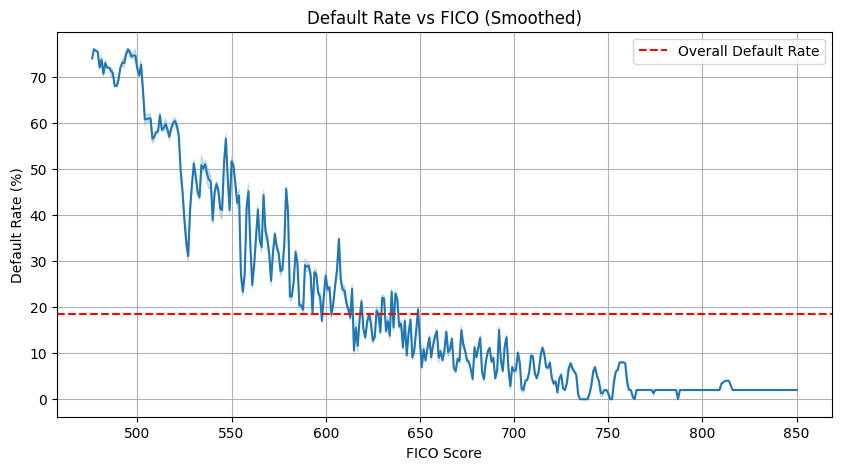

In [6]:
# Default rate overall and by FICO range
default_rate = fs_df['default'].mean() * 100
print(f'Overall Default Rate: {default_rate:.2f}%', "\n")

# calculate rollong pd
window = 50
fs_df['rolling_pd'] = fs_df['default'].rolling(window=window).mean() * 100
mask = fs_df['rolling_pd'] > 100
fs_df.loc[mask, 'rolling_pd'] = 100

# Default Rate vs FICO (Smoothed)
plt.figure(figsize=(10, 5))
sns.lineplot(x='fico_score', y='rolling_pd', data=fs_df)
plt.axhline(y=default_rate, color='red', linestyle='--', label='Overall Default Rate')
plt.title('Default Rate vs FICO (Smoothed)')
plt.xlabel('FICO Score')
plt.ylabel('Default Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

## **Choose Number of Buckets**

In [ ]:
# Implement Automatic K (Number of Buckets) Selection